In [44]:
!pip install hurst

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint, adfuller
from hurst import compute_Hc
import math
import matplotlib.pyplot as plt
#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
import glob
# import fsspec
import time
import datetime

# Finding suitable stocks

### Note- all the stock files needs to be uploaded in the in "/content" directory

In [45]:
stocks = []
path = '/content'
for filename in os.listdir(path):
    if filename.endswith("xlsx") and filename.startswith("Stock"): 
        print(filename)
        stocks.append(filename)

Stock_MUTHOOTFIN.xlsx
Stock_NHPC.xlsx
Stock_KOTAKBANK.xlsx
Stock_INDUSINDBK.xlsx
Stock_HAVELLS.xlsx
Stock_UBL.xlsx
Stock_MOTHERSUMI.xlsx
Stock_SBILIFE.xlsx
Stock_PETRONET.xlsx
Stock_ADANIPORTS.xlsx
Stock_HCLTECH.xlsx
Stock_TCS.xlsx
Stock_BIOCON.xlsx
Stock_POWERGRID.xlsx
Stock_OFSS.xlsx
Stock_PNB.xlsx
Stock_SHREECEM.xlsx
Stock_DRREDDY.xlsx
Stock_HDFCLIFE.xlsx
Stock_EICHERMOT.xlsx
Stock_ABBOTINDIA.xlsx
Stock_MARUTI.xlsx
Stock_HDFCAMC.xlsx
Stock_CONCOR.xlsx
Stock_COLPAL.xlsx
Stock_HINDUNILVR.xlsx
Stock_TATASTEEL.xlsx
Stock_INDIGO.xlsx
Stock_TATAMOTORS.xlsx
Stock_INFRATEL.xlsx
Stock_BANKBARODA.xlsx
Stock_HDFCBANK.xlsx
Stock_CIPLA.xlsx
Stock_TECHM.xlsx
Stock_AMBUJACEM.xlsx
Stock_SIEMENS.xlsx
Stock_PGHH.xlsx
Stock_DIVISLAB.xlsx
Stock_IOC.xlsx
Stock_ASIANPAINT.xlsx
Stock_BERGEPAINT.xlsx
Stock_NAUKRI.xlsx
Stock_UPL.xlsx
Stock_HINDALCO.xlsx
Stock_BAJAJ-AUTO.xlsx
Stock_BOSCHLTD.xlsx
Stock_GRASIM.xlsx
Stock_ICICIGI.xlsx
Stock_PEL.xlsx
Stock_MM.xlsx
Stock_HINDPETRO.xlsx
Stock_BAJFINANCE.xlsx
Stock

In [46]:
print(len(stocks))

100


In [47]:
price_list = []
columns = []
dates = []
for i in range(len(stocks)):
    file = stocks[i]
    df = pd.read_excel(file)
    columns.append(df.at[0, 'Symbol'])
    dates.append(df.at[0, 'Date'])
    price_list.append(df['Close'])

In [48]:
# dates to be included: 2010-01-08 to 2012-01-08
bad_dates = [dates.index(x) for x in dates if x > datetime.datetime.strptime('2010-01-08',"%Y-%m-%d")]

In [49]:
drop_companies = [column for column in columns if columns.index(column) in bad_dates]
print(drop_companies)

['MUTHOOTFIN', 'SBILIFE', 'HDFCLIFE', 'HDFCAMC', 'INDIGO', 'INFRATEL', 'ICICIGI', 'SBICARD', 'ICICIPRULI', 'GICRE', 'BANDHANBNK', 'ADANITRANS', 'COALINDIA', 'DMART']


In [50]:
good_companies = [company for company in columns if company not in drop_companies]
good_companies_ind = [columns.index(company) for company in good_companies] 

In [51]:
# 505 rows
data = pd.concat(price_list, axis=1)
data = data.iloc[0:510, :]
data.columns = columns
data.head()

,MUTHOOTFIN,NHPC,KOTAKBANK,INDUSINDBK,HAVELLS,UBL,MOTHERSUMI,SBILIFE,PETRONET,MUNDRAPORT,HCLTECH,TCS,BIOCON,POWERGRID,OFSS,PNB,SHREECEM,DRREDDY,HDFCLIFE,EICHERMOT,ABBOTINDIA,MARUTI,HDFCAMC,CONCOR,COLPAL,HINDUNILVR,TATASTEEL,INDIGO,TATAMOTORS,INFRATEL,BANKBARODA,HDFCBANK,CIPLA,TECHM,AMBUJACEM,SIEMENS,PGHH,DIVISLAB,IOC,ASIANPAINT,...,AUROPHARMA,JSWSTEEL,BAJAJHLDNG,PFC,HEROHONDA,PAGEIND,IGL,ICICIBANK,RELIANCE,HINDZINC,SBICARD,ICICIPRULI,PIDILITIND,GODREJCP,GICRE,SBIN,ULTRACEMCO,BRITANNIA,BPCL,AXISBANK,NMDC,NESTLEIND,ONGC,BANDHANBNK,NTPC,LT,LUPIN,MARICO,BHARTIARTL,MCDOWELL-N,TORNTPHARM,HDFC,ADANITRANS,COALINDIA,WIPRO,DMART,SRTRANSFIN,DLF,SUNPHARMA,GAIL
0,175.90,35.30,822.90,142.85,533.80,167.50,142.40,707.55,72.95,556.75,371.10,751.65,279.35,112.40,2376.9,925.50,1962.45,1142.15,344.60,675.65,807.0,1551.45,1815.95,1284.25,686.55,264.70,633.75,877.25,826.45,191.65,515.70,1705.70,337.55,1023.0,106.10,584.90,1719.20,670.85,314.65,1788.65,...,926.95,1022.95,645.40,255.50,1712.95,863.25,198.85,879.70,1075.50,1208.60,681.40,297.55,193.75,271.05,874.30,2291.20,966.10,1668.55,650.75,992.10,427.35,2494.65,1187.45,476.85,231.85,1691.40,1459.70,101.8,325.20,1317.80,390.45,2674.35,39.95,342.55,693.80,641.60,476.70,364.60,1507.35,415.05
1,175.90,35.60,831.05,142.70,535.75,171.75,144.75,703.65,74.60,575.95,379.45,751.85,278.80,112.75,2351.7,939.80,2045.10,1177.45,355.35,653.10,804.8,1515.85,1769.95,1269.10,685.45,263.85,649.10,923.35,812.05,193.70,530.60,1707.20,331.50,1036.1,105.30,587.70,1737.05,669.80,315.85,1794.30,...,916.25,1134.90,650.35,261.10,1717.40,865.00,200.45,888.05,1070.70,1241.50,730.90,310.25,195.30,271.45,852.15,2292.05,986.10,1671.05,640.95,1012.80,425.85,2498.95,1208.25,469.05,229.30,1694.40,1438.40,103.3,330.35,1334.65,389.50,2683.45,41.00,349.85,704.75,638.55,479.95,369.45,1552.65,418.70
2,171.35,36.25,841.15,146.10,536.10,172.20,141.75,694.55,76.50,604.50,368.00,734.85,290.80,113.55,2346.6,935.35,2119.25,1207.65,385.30,647.65,790.0,1461.65,1779.65,1313.20,687.30,265.35,642.05,1004.10,813.30,197.75,533.85,1708.35,344.90,1041.2,105.95,593.75,1711.20,687.80,315.40,1788.90,...,907.45,1148.95,641.25,259.70,1695.40,859.85,197.60,894.85,1088.00,1229.00,689.20,309.70,220.35,264.00,834.85,2305.80,987.30,1655.85,631.30,995.80,427.15,2502.85,1223.50,475.70,228.20,1675.65,1469.20,102.6,326.85,1384.55,387.40,2696.35,40.90,330.75,690.50,634.85,472.95,378.55,1572.80,415.90
3,176.35,35.60,850.60,142.80,539.60,168.85,144.65,696.75,76.35,597.35,360.15,714.40,290.15,114.55,2323.4,922.50,2252.65,1188.95,395.20,638.60,767.0,1453.30,1749.05,1275.90,693.55,264.80,649.80,988.95,785.50,201.50,537.05,1712.80,342.05,1018.3,105.80,615.65,1727.80,709.90,310.45,1770.65,...,888.75,1124.45,628.15,259.90,1653.20,870.00,196.20,886.40,1106.05,1287.95,692.05,304.25,210.35,261.90,855.45,2292.90,978.35,1649.05,619.05,1002.85,419.85,2489.35,1224.80,483.45,228.25,1667.60,1440.65,101.6,329.40,1364.05,397.35,2646.15,40.20,326.05,678.25,616.90,487.50,374.50,1548.85,426.35
4,175.10,35.35,845.35,142.30,529.60,167.00,142.40,698.65,77.40,596.65,351.75,699.80,289.10,114.85,2323.8,923.85,2220.05,1194.10,374.85,647.20,785.1,1433.15,1748.90,1294.10,682.95,265.95,648.45,1036.90,789.80,204.35,539.20,1715.05,341.10,1045.1,105.90,631.00,1707.35,691.95,315.75,1799.90,...,896.35,1118.05,625.20,258.45,1645.20,869.75,194.85,873.95,1103.15,1262.20,724.50,313.75,207.90,268.30,861.95,2286.05,990.30,1652.70,629.55,1015.95,419.55,2568.20,1215.70,486.05,231.10,1678.15,1439.40,101.2,325.05,1347.25,391.35,2600.05,38.05,322.80,668.05,614.40,497.75,389.90,1574.95,428.75


In [52]:
# checking for 510 rows of data
for company in good_companies:
    if data[company].isnull().values.any():
        drop_companies.append(company)
print(len(drop_companies))
# all the companies in good_companies have the required data

14


In [53]:
good_companies = [company for company in columns if company not in drop_companies]
good_companies_ind = [columns.index(company) for company in good_companies] 

print('companies to drop:')
print(drop_companies)
print('companies to retain:')
print(good_companies)

companies to drop:
['MUTHOOTFIN', 'SBILIFE', 'HDFCLIFE', 'HDFCAMC', 'INDIGO', 'INFRATEL', 'ICICIGI', 'SBICARD', 'ICICIPRULI', 'GICRE', 'BANDHANBNK', 'ADANITRANS', 'COALINDIA', 'DMART']
companies to retain:
['NHPC', 'KOTAKBANK', 'INDUSINDBK', 'HAVELLS', 'UBL', 'MOTHERSUMI', 'PETRONET', 'MUNDRAPORT', 'HCLTECH', 'TCS', 'BIOCON', 'POWERGRID', 'OFSS', 'PNB', 'SHREECEM', 'DRREDDY', 'EICHERMOT', 'ABBOTINDIA', 'MARUTI', 'CONCOR', 'COLPAL', 'HINDUNILVR', 'TATASTEEL', 'TATAMOTORS', 'BANKBARODA', 'HDFCBANK', 'CIPLA', 'TECHM', 'AMBUJACEM', 'SIEMENS', 'PGHH', 'DIVISLAB', 'IOC', 'ASIANPAINT', 'BERGEPAINT', 'NAUKRI', 'UNIPHOS', 'HINDALCO', 'BAJAJ-AUTO', 'BOSCHLTD', 'GRASIM', 'PIRHEALTH', 'M&M', 'HINDPETRO', 'BAJAUTOFIN', 'INFOSYSTCH', 'ACC', 'ZEEL', 'CADILAHC', 'DABUR', 'BAJAJFINSV', 'ITC', 'TITAN', 'AUROPHARMA', 'JSWSTEEL', 'BAJAJHLDNG', 'PFC', 'HEROHONDA', 'PAGEIND', 'IGL', 'ICICIBANK', 'RELIANCE', 'HINDZINC', 'PIDILITIND', 'GODREJCP', 'SBIN', 'ULTRACEMCO', 'BRITANNIA', 'BPCL', 'AXISBANK', 'NMDC', 

# Data Processing

In [54]:
drop_stocks = drop_companies
print(drop_stocks)

['MUTHOOTFIN', 'SBILIFE', 'HDFCLIFE', 'HDFCAMC', 'INDIGO', 'INFRATEL', 'ICICIGI', 'SBICARD', 'ICICIPRULI', 'GICRE', 'BANDHANBNK', 'ADANITRANS', 'COALINDIA', 'DMART']


In [55]:
# renaming with full extension to match with file names
for i, val in enumerate(drop_stocks):
  drop_stocks[i] = "Stock_"+val+".xlsx"

In [56]:
# removing stocks to be dropped from the final list
for val in drop_stocks:
  stocks.remove(val)
print(len(stocks))  

86


In [57]:
# checking the number of days in selected stocks
a = []
mean_reaturn=[]
std_returns=[]
for i in range(0,len(stocks)):
  df = pd.read_excel(stocks[i],usecols=['Close', 'Date'])
  df = df.drop_duplicates()  
  # print(stocks[i][6:-5], df.shape[0])
  a.append(df.shape[0])

# finding minimum and maximum entries    
print(min(a))
print(max(a))    

2658
2668


In [58]:
# reading first column mannualy
df = pd.read_excel(stocks[0],usecols=['Close', 'Date'])
df = df.drop_duplicates()
df.set_index('Date', inplace=True)
returns = df['Close'].pct_change()
returns = returns.dropna()

# normalizing returns, for not normalizwd returns comment this line
returns = (returns - returns.mean())/returns.std()

df_n_rts = returns.to_frame()

# renaming column name
df_n_rts.columns = [stocks[0][6:-5]]
df_n_rts = df_n_rts.reset_index()
df_n_rts = df_n_rts.drop_duplicates()
df_n_rts

,Date,NHPC
0,2010-01-05,0.463214
1,2010-01-06,0.992836
2,2010-01-07,-0.971001
3,2010-01-08,-0.379043
4,2010-01-11,-0.381738
...,...,...
2662,2020-09-25,0.680353
2663,2020-09-28,0.537990
2664,2020-09-29,-0.130644
2665,2020-09-30,-0.529979


In [59]:
# checking for duplicates
dates = df_n_rts['Date']
df_n_rts[dates.isin(dates[dates.duplicated()])].sort_index()

,Date,NHPC


In [60]:
# merging rest of the columns interatively
for i in range(1,len(stocks)):
  df = pd.read_excel(stocks[i],usecols=['Close', 'Date'])
  df = df.drop_duplicates()
  df.set_index('Date', inplace=True)  
  returns = df['Close'].pct_change()
  returns = returns.dropna()

  # for not normalized returns comment this line
  returns = (returns - returns.mean())/returns.std()
  
  returns = returns.to_frame()
  returns.columns = [stocks[i][6:-5]]
  returns = returns.reset_index()
  returns = returns.drop_duplicates() 
  
  # merging through inner product on Date as key  
  df_n_rts = pd.merge(df_n_rts, returns, how='inner', on='Date')

df_n_rts

,Date,NHPC,KOTAKBANK,INDUSINDBK,HAVELLS,UBL,MOTHERSUMI,PETRONET,ADANIPORTS,HCLTECH,TCS,BIOCON,POWERGRID,OFSS,PNB,SHREECEM,DRREDDY,EICHERMOT,ABBOTINDIA,MARUTI,CONCOR,COLPAL,HINDUNILVR,TATASTEEL,TATAMOTORS,BANKBARODA,HDFCBANK,CIPLA,TECHM,AMBUJACEM,SIEMENS,PGHH,DIVISLAB,IOC,ASIANPAINT,BERGEPAINT,NAUKRI,UPL,HINDALCO,BAJAJ-AUTO,...,ACC,ZEEL,CADILAHC,DABUR,BAJAJFINSV,ITC,TITAN,AUROPHARMA,JSWSTEEL,BAJAJHLDNG,PFC,HEROMOTOCO,PAGEIND,IGL,ICICIBANK,RELIANCE,HINDZINC,PIDILITIND,GODREJCP,SBIN,ULTRACEMCO,BRITANNIA,BPCL,AXISBANK,NMDC,NESTLEIND,ONGC,NTPC,LT,LUPIN,MARICO,BHARTIARTL,MCDOWELL-N,TORNTPHARM,HDFC,WIPRO,SRTRANSFIN,DLF,SUNPHARMA,GAIL
0,2010-01-11,-0.381738,0.149513,0.021703,0.206124,0.293670,0.751052,1.437616,1.180844,0.405224,1.042012,0.231773,0.012800,-0.733852,0.958787,1.222966,0.257369,-0.267461,-0.234989,0.767846,0.055691,0.563299,-0.021374,0.000570,0.015335,0.453730,-0.185340,0.184441,-0.273457,0.074205,1.021880,-0.251591,-0.262363,0.410222,-0.100760,1.764100,-0.175136,-0.333066,-0.371765,0.428710,...,0.175563,1.558974,-0.231794,0.506160,0.138305,0.015662,-0.315983,-0.217272,0.720521,0.317032,1.416741,1.000302,0.229257,0.683486,-0.203414,-0.984714,0.486088,0.084891,-0.221883,-0.289385,0.032248,-0.041982,-0.103229,1.178847,1.493581,0.059424,0.047987,0.497237,-0.023980,-0.742734,-0.085694,0.560537,0.317156,-0.659224,-0.012108,-0.471272,0.266856,0.808895,-0.011566,0.388660
1,2010-01-12,-0.848278,-1.356701,-0.736378,0.167212,-0.085390,-0.617795,-1.595972,0.512092,1.512690,2.591801,-0.434342,-1.004001,1.165654,-0.809773,-2.165236,0.418135,-1.595682,-1.155255,-0.544990,-0.206218,-0.626165,-1.023971,-1.522832,-0.158879,-0.347508,-0.337182,-0.492110,0.263891,-1.346004,-1.395708,-0.456437,-0.399680,-0.107869,1.064790,-0.751111,-0.108678,-1.596978,-0.883193,1.044611,...,-1.118495,0.331823,-0.580778,-1.509251,-1.125385,-1.293933,-0.122038,-0.273272,-0.438030,-0.832132,0.201961,-1.038820,-0.132413,-0.183958,-1.159168,0.104089,0.625740,-1.040961,-0.045195,-1.006264,-0.438797,0.316419,-0.027937,-0.013132,-0.793246,0.048767,-0.790886,-0.904814,0.057021,-0.289950,0.641691,-0.993350,-0.022915,-0.341549,-0.670184,2.329654,0.127078,-1.293442,-0.075544,-0.477294
2,2010-01-13,0.630289,-0.562726,-0.805317,-0.386106,-0.108993,0.204519,2.149605,1.312421,1.165008,2.651131,1.378631,1.014483,1.424303,-0.203462,0.495920,0.873239,-0.485958,-1.785329,-0.494092,0.349023,1.065293,0.028801,0.937967,-0.055458,-0.147278,-0.162176,0.362249,1.615120,2.387845,0.922962,1.517370,0.860698,0.749045,0.300072,0.019089,-0.050665,0.731090,0.748502,0.097703,...,3.142580,1.153616,-0.270740,-0.084116,-0.530582,-0.226337,-0.304806,-0.369704,0.388157,-0.402354,0.135639,-0.643979,-0.560548,0.085282,-0.101466,0.166900,-0.307514,-0.312032,-0.012906,-0.438099,2.725062,-0.180374,0.123223,-0.319314,0.005459,-0.405831,0.163956,0.014383,-0.174242,-0.194743,0.434739,-0.589078,-0.856935,0.286468,-0.272883,1.494915,0.308064,0.332743,-0.586017,-0.204019
3,2010-01-14,0.079668,0.601009,0.081012,-0.406877,-0.073736,1.067047,0.812560,-0.590705,-0.928029,-0.611981,-0.023976,1.417722,1.919085,0.140850,1.228356,0.383591,-0.028344,1.311637,-0.559818,-0.012255,-1.121780,-1.656928,0.565042,-0.116097,0.398831,-0.152590,-0.211496,-0.227617,-0.408040,1.611446,0.172563,-0.223869,0.280051,0.499461,0.052926,0.309584,-0.726753,-0.081755,0.027219,...,0.532655,0.166193,0.166554,0.082640,0.033249,-0.166424,1.114622,1.218347,1.170295,0.658895,1.459174,-0.169022,-0.302921,1.526245,-0.246903,1.462391,0.069859,0.852878,0.253419,-0.299413,0.600232,0.457396,-0.239338,0.885571,0.135076,2.017262,1.203475,0.435081,-0.138619,-0.206019,0.675678,-0.068267,-0.055053,0.747052,-0.327638,1.695132,0.125264,-0.394273,0.281843,0.474539
4,2010-01-15,0.389645,-0.155566,1.151128,-0.777639,0.528285,0.650360,-0.776413,0.526739,-0.108702,0.740268,-0.004926,0.744192,-0.300630,-0.500138,-0.975106,-0.382729,1.165914,0.819444,-0.091971,0.797816,-0.021985,0.030871,-0.171849,0.631441,-0.305922,0.248667,1.630351,2.097570,2.805945,-0.288719,

## calculating not normalized returns

In [61]:
# reading first column mannualy
df = pd.read_excel(stocks[0],usecols=['Close', 'Date'])
df = df.drop_duplicates()
df.set_index('Date', inplace=True)
returns = df['Close'].pct_change()
returns = returns.dropna()

# normalizing returns, for not normalizwd returns comment this line
#returns = (returns - returns.mean())/returns.std()

df_un = returns.to_frame()

# renaming column name
df_un.columns = [stocks[0][6:-5]]
df_un = df_un.reset_index()
df_un = df_un.drop_duplicates()
df_un

,Date,NHPC
0,2010-01-05,0.008499
1,2010-01-06,0.018258
2,2010-01-07,-0.017931
3,2010-01-08,-0.007022
4,2010-01-11,-0.007072
...,...,...
2662,2020-09-25,0.012500
2663,2020-09-28,0.009877
2664,2020-09-29,-0.002445
2665,2020-09-30,-0.009804


In [62]:
# merging rest of the columns interatively
for i in range(1,len(good_companies)):
  df = pd.read_excel(stocks[i],usecols=['Close', 'Date'])
  df = df.drop_duplicates()
  df.set_index('Date', inplace=True)  
  returns = df['Close'].pct_change()
  returns = returns.dropna()

  # for not normalized returns comment this line
  #returns = (returns - returns.mean())/returns.std()
  
  returns = returns.to_frame()
  returns.columns = [stocks[i][6:-5]]
  returns = returns.reset_index()
  returns = returns.drop_duplicates() 
  
  # merging through inner product on Date as key  
  df_un = pd.merge(df_un, returns, how='inner', on='Date')

df_un

,Date,NHPC,KOTAKBANK,INDUSINDBK,HAVELLS,UBL,MOTHERSUMI,PETRONET,ADANIPORTS,HCLTECH,TCS,BIOCON,POWERGRID,OFSS,PNB,SHREECEM,DRREDDY,EICHERMOT,ABBOTINDIA,MARUTI,CONCOR,COLPAL,HINDUNILVR,TATASTEEL,TATAMOTORS,BANKBARODA,HDFCBANK,CIPLA,TECHM,AMBUJACEM,SIEMENS,PGHH,DIVISLAB,IOC,ASIANPAINT,BERGEPAINT,NAUKRI,UPL,HINDALCO,BAJAJ-AUTO,...,ACC,ZEEL,CADILAHC,DABUR,BAJAJFINSV,ITC,TITAN,AUROPHARMA,JSWSTEEL,BAJAJHLDNG,PFC,HEROMOTOCO,PAGEIND,IGL,ICICIBANK,RELIANCE,HINDZINC,PIDILITIND,GODREJCP,SBIN,ULTRACEMCO,BRITANNIA,BPCL,AXISBANK,NMDC,NESTLEIND,ONGC,NTPC,LT,LUPIN,MARICO,BHARTIARTL,MCDOWELL-N,TORNTPHARM,HDFC,WIPRO,SRTRANSFIN,DLF,SUNPHARMA,GAIL
0,2010-01-11,-0.007072,0.003845,0.001405,0.006326,0.008383,0.022121,0.032300,0.034023,0.009950,0.020577,0.006745,0.000435,-0.012071,0.028089,0.023468,0.005067,-0.006258,-0.002726,0.015072,0.001120,0.010323,0.000564,0.000077,0.000443,0.013260,-0.004023,0.003518,-0.006315,0.001889,0.020444,-0.002929,-0.004769,0.009818,-0.001695,0.042693,-0.003655,-0.007351,-0.009233,0.008639,...,0.003289,0.042582,-0.005643,0.009991,0.004429,0.000390,-0.008084,-0.006248,0.022003,0.006398,0.040240,0.018964,0.006266,0.018732,-0.005206,-0.019626,0.013231,0.002646,-0.004473,-0.008246,0.001262,-0.000242,-0.002621,0.032925,0.033488,0.001724,0.000658,0.008005,-0.000507,-0.017368,-0.000988,0.011998,0.009686,-0.012649,0.000019,-0.009954,0.007634,0.024493,-0.000159,0.008513
1,2010-01-12,-0.015670,-0.030108,-0.017895,0.005254,-0.001188,-0.017520,-0.034418,0.014993,0.035468,0.050196,-0.010823,-0.014360,0.019776,-0.025005,-0.038642,0.007791,-0.043302,-0.018390,-0.009452,-0.004979,-0.010507,-0.014844,-0.035389,-0.004872,-0.010707,-0.007581,-0.007742,0.006789,-0.025448,-0.026790,-0.005933,-0.007696,-0.002823,0.026101,-0.016535,-0.001921,-0.037881,-0.022423,0.020455,...,-0.018685,0.009325,-0.014625,-0.027278,-0.024036,-0.025526,-0.002560,-0.008027,-0.012821,-0.014383,0.005765,-0.018880,-0.001371,-0.004030,-0.030653,0.002635,0.017007,-0.019429,-0.000374,-0.028229,-0.007009,0.008534,-0.000557,-0.000095,-0.018335,0.001561,-0.021003,-0.015239,0.001163,-0.006575,0.013353,-0.020368,-0.000404,-0.006082,-0.015557,0.048987,0.003888,-0.038803,-0.001842,-0.011101
2,2010-01-13,0.011577,-0.012211,-0.019650,-0.009986,-0.001784,0.006294,0.047959,0.037767,0.027457,0.051330,0.036992,0.015011,0.024112,-0.006803,0.010140,0.015502,-0.012352,-0.029114,-0.008501,0.007951,0.019114,0.001335,0.021901,-0.001717,-0.004718,-0.003480,0.006477,0.039740,0.046422,0.018511,0.023017,0.019170,0.018085,0.007864,0.001601,-0.000408,0.018354,0.019660,0.002289,...,0.053672,0.031596,-0.006645,-0.000924,-0.010638,-0.004399,-0.007766,-0.011091,0.012012,-0.006611,0.003883,-0.011552,-0.010412,0.003035,-0.002492,0.003919,-0.008227,-0.005137,0.000375,-0.012391,0.048548,-0.003631,0.003585,-0.008577,-0.000235,-0.005394,0.003653,0.000000,-0.003603,-0.004306,0.009273,-0.011947,-0.025152,0.006900,-0.006153,0.031421,0.008739,0.010158,-0.015269,-0.004911
3,2010-01-14,0.001431,0.014022,0.002915,-0.010558,-0.000893,0.031272,0.018553,-0.016388,-0.020770,-0.011033,0.000000,0.020879,0.032407,0.003534,0.023567,0.007205,0.000411,0.023598,-0.009729,-0.000462,-0.019187,-0.024571,0.013219,-0.003567,0.011618,-0.003256,-0.003072,-0.005197,-0.007394,0.031962,0.003293,-0.003949,0.006642,0.012619,0.002398,0.008987,-0.016860,-0.001753,0.000937,...,0.009353,0.004836,0.004609,0.002159,0.002062,-0.003213,0.032669,0.039368,0.035522,0.012580,0.041444,-0.002737,-0.004972,0.040847,-0.006364,0.030406,0.001977,0.017703,0.006552,-0.008525,0.011236,0.011985,-0.006351,0.024801,0.002702,0.031675,0.030494,0.006975,-0.002869,-0.004575,0.014023,-0.001099,-0.001358,0.016421,-0.007449,0.035634,0.003839,-0.011731,0.007559,0.010458
4,2010-01-15,0.007143,-0.003033,0.030160,-0.020770,0.014307,0.019205,-0.016393,0.015410,-0.001891,0.014811,0.000502,0.011078,-0.004807,-0.015710,-0.016825,-0.005780,0.033720,0.015221,-0.000990,0.018402,0.000073,0.001367,-0.003937,0.019242,-0.009463,0.006147,0.027582,0.051505,0.054469,-0.005162,0.0203

# PCA

In [63]:
df_n_rts.head(5)

,Date,NHPC,KOTAKBANK,INDUSINDBK,HAVELLS,UBL,MOTHERSUMI,PETRONET,ADANIPORTS,HCLTECH,TCS,BIOCON,POWERGRID,OFSS,PNB,SHREECEM,DRREDDY,EICHERMOT,ABBOTINDIA,MARUTI,CONCOR,COLPAL,HINDUNILVR,TATASTEEL,TATAMOTORS,BANKBARODA,HDFCBANK,CIPLA,TECHM,AMBUJACEM,SIEMENS,PGHH,DIVISLAB,IOC,ASIANPAINT,BERGEPAINT,NAUKRI,UPL,HINDALCO,BAJAJ-AUTO,...,ACC,ZEEL,CADILAHC,DABUR,BAJAJFINSV,ITC,TITAN,AUROPHARMA,JSWSTEEL,BAJAJHLDNG,PFC,HEROMOTOCO,PAGEIND,IGL,ICICIBANK,RELIANCE,HINDZINC,PIDILITIND,GODREJCP,SBIN,ULTRACEMCO,BRITANNIA,BPCL,AXISBANK,NMDC,NESTLEIND,ONGC,NTPC,LT,LUPIN,MARICO,BHARTIARTL,MCDOWELL-N,TORNTPHARM,HDFC,WIPRO,SRTRANSFIN,DLF,SUNPHARMA,GAIL
0,2010-01-11,-0.381738,0.149513,0.021703,0.206124,0.293670,0.751052,1.437616,1.180844,0.405224,1.042012,0.231773,0.012800,-0.733852,0.958787,1.222966,0.257369,-0.267461,-0.234989,0.767846,0.055691,0.563299,-0.021374,0.000570,0.015335,0.453730,-0.185340,0.184441,-0.273457,0.074205,1.021880,-0.251591,-0.262363,0.410222,-0.100760,1.764100,-0.175136,-0.333066,-0.371765,0.428710,...,0.175563,1.558974,-0.231794,0.506160,0.138305,0.015662,-0.315983,-0.217272,0.720521,0.317032,1.416741,1.000302,0.229257,0.683486,-0.203414,-0.984714,0.486088,0.084891,-0.221883,-0.289385,0.032248,-0.041982,-0.103229,1.178847,1.493581,0.059424,0.047987,0.497237,-0.023980,-0.742734,-0.085694,0.560537,0.317156,-0.659224,-0.012108,-0.471272,0.266856,0.808895,-0.011566,0.388660
1,2010-01-12,-0.848278,-1.356701,-0.736378,0.167212,-0.085390,-0.617795,-1.595972,0.512092,1.512690,2.591801,-0.434342,-1.004001,1.165654,-0.809773,-2.165236,0.418135,-1.595682,-1.155255,-0.544990,-0.206218,-0.626165,-1.023971,-1.522832,-0.158879,-0.347508,-0.337182,-0.492110,0.263891,-1.346004,-1.395708,-0.456437,-0.399680,-0.107869,1.064790,-0.751111,-0.108678,-1.596978,-0.883193,1.044611,...,-1.118495,0.331823,-0.580778,-1.509251,-1.125385,-1.293933,-0.122038,-0.273272,-0.438030,-0.832132,0.201961,-1.038820,-0.132413,-0.183958,-1.159168,0.104089,0.625740,-1.040961,-0.045195,-1.006264,-0.438797,0.316419,-0.027937,-0.013132,-0.793246,0.048767,-0.790886,-0.904814,0.057021,-0.289950,0.641691,-0.993350,-0.022915,-0.341549,-0.670184,2.329654,0.127078,-1.293442,-0.075544,-0.477294
2,2010-01-13,0.630289,-0.562726,-0.805317,-0.386106,-0.108993,0.204519,2.149605,1.312421,1.165008,2.651131,1.378631,1.014483,1.424303,-0.203462,0.495920,0.873239,-0.485958,-1.785329,-0.494092,0.349023,1.065293,0.028801,0.937967,-0.055458,-0.147278,-0.162176,0.362249,1.615120,2.387845,0.922962,1.517370,0.860698,0.749045,0.300072,0.019089,-0.050665,0.731090,0.748502,0.097703,...,3.142580,1.153616,-0.270740,-0.084116,-0.530582,-0.226337,-0.304806,-0.369704,0.388157,-0.402354,0.135639,-0.643979,-0.560548,0.085282,-0.101466,0.166900,-0.307514,-0.312032,-0.012906,-0.438099,2.725062,-0.180374,0.123223,-0.319314,0.005459,-0.405831,0.163956,0.014383,-0.174242,-0.194743,0.434739,-0.589078,-0.856935,0.286468,-0.272883,1.494915,0.308064,0.332743,-0.586017,-0.204019
3,2010-01-14,0.079668,0.601009,0.081012,-0.406877,-0.073736,1.067047,0.812560,-0.590705,-0.928029,-0.611981,-0.023976,1.417722,1.919085,0.140850,1.228356,0.383591,-0.028344,1.311637,-0.559818,-0.012255,-1.121780,-1.656928,0.565042,-0.116097,0.398831,-0.152590,-0.211496,-0.227617,-0.408040,1.611446,0.172563,-0.223869,0.280051,0.499461,0.052926,0.309584,-0.726753,-0.081755,0.027219,...,0.532655,0.166193,0.166554,0.082640,0.033249,-0.166424,1.114622,1.218347,1.170295,0.658895,1.459174,-0.169022,-0.302921,1.526245,-0.246903,1.462391,0.069859,0.852878,0.253419,-0.299413,0.600232,0.457396,-0.239338,0.885571,0.135076,2.017262,1.203475,0.435081,-0.138619,-0.206019,0.675678,-0.068267,-0.055053,0.747052,-0.327638,1.695132,0.125264,-0.394273,0.281843,0.474539
4,2010-01-15,0.389645,-0.155566,1.151128,-0.777639,0.528285,0.650360,-0.776413,0.526739,-0.108702,0.740268,-0.004926,0.744192,-0.300630,-0.500138,-0.975106,-0.382729,1.165914,0.819444,-0.091971,0.797816,-0.021985,0.030871,-0.171849,0.631441,-0.305922,0.248667,1.630351,2.097570,2.805945,-0.288719,

In [64]:
for x in df_n_rts.columns:
  if x!= 'Date':
    df_n_rts[x] = df_n_rts[x]/100

In [65]:
df_n_rts.head(5)

,Date,NHPC,KOTAKBANK,INDUSINDBK,HAVELLS,UBL,MOTHERSUMI,PETRONET,ADANIPORTS,HCLTECH,TCS,BIOCON,POWERGRID,OFSS,PNB,SHREECEM,DRREDDY,EICHERMOT,ABBOTINDIA,MARUTI,CONCOR,COLPAL,HINDUNILVR,TATASTEEL,TATAMOTORS,BANKBARODA,HDFCBANK,CIPLA,TECHM,AMBUJACEM,SIEMENS,PGHH,DIVISLAB,IOC,ASIANPAINT,BERGEPAINT,NAUKRI,UPL,HINDALCO,BAJAJ-AUTO,...,ACC,ZEEL,CADILAHC,DABUR,BAJAJFINSV,ITC,TITAN,AUROPHARMA,JSWSTEEL,BAJAJHLDNG,PFC,HEROMOTOCO,PAGEIND,IGL,ICICIBANK,RELIANCE,HINDZINC,PIDILITIND,GODREJCP,SBIN,ULTRACEMCO,BRITANNIA,BPCL,AXISBANK,NMDC,NESTLEIND,ONGC,NTPC,LT,LUPIN,MARICO,BHARTIARTL,MCDOWELL-N,TORNTPHARM,HDFC,WIPRO,SRTRANSFIN,DLF,SUNPHARMA,GAIL
0,2010-01-11,-0.003817,0.001495,0.000217,0.002061,0.002937,0.007511,0.014376,0.011808,0.004052,0.010420,0.002318,0.000128,-0.007339,0.009588,0.012230,0.002574,-0.002675,-0.002350,0.007678,0.000557,0.005633,-0.000214,0.000006,0.000153,0.004537,-0.001853,0.001844,-0.002735,0.000742,0.010219,-0.002516,-0.002624,0.004102,-0.001008,0.017641,-0.001751,-0.003331,-0.003718,0.004287,...,0.001756,0.015590,-0.002318,0.005062,0.001383,0.000157,-0.003160,-0.002173,0.007205,0.003170,0.014167,0.010003,0.002293,0.006835,-0.002034,-0.009847,0.004861,0.000849,-0.002219,-0.002894,0.000322,-0.000420,-0.001032,0.011788,0.014936,0.000594,0.000480,0.004972,-0.000240,-0.007427,-0.000857,0.005605,0.003172,-0.006592,-0.000121,-0.004713,0.002669,0.008089,-0.000116,0.003887
1,2010-01-12,-0.008483,-0.013567,-0.007364,0.001672,-0.000854,-0.006178,-0.015960,0.005121,0.015127,0.025918,-0.004343,-0.010040,0.011657,-0.008098,-0.021652,0.004181,-0.015957,-0.011553,-0.005450,-0.002062,-0.006262,-0.010240,-0.015228,-0.001589,-0.003475,-0.003372,-0.004921,0.002639,-0.013460,-0.013957,-0.004564,-0.003997,-0.001079,0.010648,-0.007511,-0.001087,-0.015970,-0.008832,0.010446,...,-0.011185,0.003318,-0.005808,-0.015093,-0.011254,-0.012939,-0.001220,-0.002733,-0.004380,-0.008321,0.002020,-0.010388,-0.001324,-0.001840,-0.011592,0.001041,0.006257,-0.010410,-0.000452,-0.010063,-0.004388,0.003164,-0.000279,-0.000131,-0.007932,0.000488,-0.007909,-0.009048,0.000570,-0.002900,0.006417,-0.009934,-0.000229,-0.003415,-0.006702,0.023297,0.001271,-0.012934,-0.000755,-0.004773
2,2010-01-13,0.006303,-0.005627,-0.008053,-0.003861,-0.001090,0.002045,0.021496,0.013124,0.011650,0.026511,0.013786,0.010145,0.014243,-0.002035,0.004959,0.008732,-0.004860,-0.017853,-0.004941,0.003490,0.010653,0.000288,0.009380,-0.000555,-0.001473,-0.001622,0.003622,0.016151,0.023878,0.009230,0.015174,0.008607,0.007490,0.003001,0.000191,-0.000507,0.007311,0.007485,0.000977,...,0.031426,0.011536,-0.002707,-0.000841,-0.005306,-0.002263,-0.003048,-0.003697,0.003882,-0.004024,0.001356,-0.006440,-0.005605,0.000853,-0.001015,0.001669,-0.003075,-0.003120,-0.000129,-0.004381,0.027251,-0.001804,0.001232,-0.003193,0.000055,-0.004058,0.001640,0.000144,-0.001742,-0.001947,0.004347,-0.005891,-0.008569,0.002865,-0.002729,0.014949,0.003081,0.003327,-0.005860,-0.002040
3,2010-01-14,0.000797,0.006010,0.000810,-0.004069,-0.000737,0.010670,0.008126,-0.005907,-0.009280,-0.006120,-0.000240,0.014177,0.019191,0.001409,0.012284,0.003836,-0.000283,0.013116,-0.005598,-0.000123,-0.011218,-0.016569,0.005650,-0.001161,0.003988,-0.001526,-0.002115,-0.002276,-0.004080,0.016114,0.001726,-0.002239,0.002801,0.004995,0.000529,0.003096,-0.007268,-0.000818,0.000272,...,0.005327,0.001662,0.001666,0.000826,0.000332,-0.001664,0.011146,0.012183,0.011703,0.006589,0.014592,-0.001690,-0.003029,0.015262,-0.002469,0.014624,0.000699,0.008529,0.002534,-0.002994,0.006002,0.004574,-0.002393,0.008856,0.001351,0.020173,0.012035,0.004351,-0.001386,-0.002060,0.006757,-0.000683,-0.000551,0.007471,-0.003276,0.016951,0.001253,-0.003943,0.002818,0.004745
4,2010-01-15,0.003896,-0.001556,0.011511,-0.007776,0.005283,0.006504,-0.007764,0.005267,-0.001087,0.007403,-0.000049,0.007442,-0.003006,-0.005001,-0.009751,-0.003827,0.011659,0.008194,-0.000920,0.007978,-0.000220,0.000309,-0.001718,0.006314,-0.003059,0.002487,0.016304,0.020976,0.028059,-0.002887,

In [66]:
companies = [x for x in df_n_rts.columns if x != 'Date']
returns_data = np.array(df_n_rts[companies].iloc[0:505])
print(returns_data.shape)

(505, 86)


In [67]:
pca_obj = PCA(n_components=30)
data = pca_obj.fit_transform(returns_data.T)
data = data

In [68]:
print(data.shape)

(86, 30)


In [69]:
print(data)

[[-0.00530598 -0.0002381   0.01022587 ... -0.01536096  0.01310489
   0.00495798]
 [-0.01542209 -0.04041749 -0.01512636 ... -0.02544781 -0.02441453
  -0.02140061]
 [-0.02688051 -0.0329988   0.00442476 ...  0.01896257  0.02481421
  -0.00540189]
 ...
 [-0.02066967 -0.0403223   0.00627238 ...  0.02504294  0.00158563
  -0.00779816]
 [-0.02199375  0.08792631 -0.03801585 ...  0.00655256  0.00588318
  -0.01028828]
 [-0.00848152  0.0107607  -0.00877896 ...  0.00847205 -0.00491808
   0.00258801]]


# Clustering

The labels = -1 indicate that they are in no cluster.

The cluster label indicates the index of the cluster in which they are

In [70]:
clustering_usng_rts = OPTICS(min_samples=2).fit(data)
labels_usng_rts = clustering_usng_rts.labels_
labels_usng_rts

array([ 0, -1, -1, -1, -1, -1, -1, -1,  6,  6, -1,  4,  5,  0, -1, -1, -1,
       -1, -1,  2, -1, -1,  3, -1,  0, -1, -1,  5,  8, -1, -1, -1,  7,  2,
       -1, -1, -1,  3,  9, -1, -1, -1, -1,  7,  3,  6,  8, -1, -1,  9, -1,
       -1, -1, -1,  3, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  8,  9,
        7,  1, -1, -1, -1,  4, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1])

In [71]:
N = (labels_usng_rts.max()+1)
List_index = [None]*N
for i in range(N):
  List_index[i] = []

for idx,val in enumerate(labels_usng_rts):
  if (val!= -1):
    List_index[val].append(idx)

List_name = [None]*N
for i in range(N):
  List_name[i] = []

for idx, cluster in enumerate(List_index):
  for company in cluster:
    # print(df.columns[company])
    # i = 
    List_name[idx].append(companies[company])

List_name

[['NHPC', 'PNB', 'BANKBARODA'],
 ['ICICIBANK', 'AXISBANK', 'DLF'],
 ['CONCOR', 'ASIANPAINT'],
 ['TATASTEEL', 'HINDALCO', 'BAJFINANCE', 'JSWSTEEL'],
 ['POWERGRID', 'NTPC'],
 ['OFSS', 'TECHM'],
 ['HCLTECH', 'TCS', 'INFY'],
 ['IOC', 'HINDPETRO', 'BPCL'],
 ['AMBUJACEM', 'ACC', 'ULTRACEMCO'],
 ['BAJAJ-AUTO', 'DABUR', 'BRITANNIA']]

In [72]:
possible = []
for x in List_name:
  for i in range(len(x)):
     for j in range(i+1, len(x)):
       possible.append([x[i],x[j]])

possible

[['NHPC', 'PNB'],
 ['NHPC', 'BANKBARODA'],
 ['PNB', 'BANKBARODA'],
 ['ICICIBANK', 'AXISBANK'],
 ['ICICIBANK', 'DLF'],
 ['AXISBANK', 'DLF'],
 ['CONCOR', 'ASIANPAINT'],
 ['TATASTEEL', 'HINDALCO'],
 ['TATASTEEL', 'BAJFINANCE'],
 ['TATASTEEL', 'JSWSTEEL'],
 ['HINDALCO', 'BAJFINANCE'],
 ['HINDALCO', 'JSWSTEEL'],
 ['BAJFINANCE', 'JSWSTEEL'],
 ['POWERGRID', 'NTPC'],
 ['OFSS', 'TECHM'],
 ['HCLTECH', 'TCS'],
 ['HCLTECH', 'INFY'],
 ['TCS', 'INFY'],
 ['IOC', 'HINDPETRO'],
 ['IOC', 'BPCL'],
 ['HINDPETRO', 'BPCL'],
 ['AMBUJACEM', 'ACC'],
 ['AMBUJACEM', 'ULTRACEMCO'],
 ['ACC', 'ULTRACEMCO'],
 ['BAJAJ-AUTO', 'DABUR'],
 ['BAJAJ-AUTO', 'BRITANNIA'],
 ['DABUR', 'BRITANNIA']]

# Pair Selection Rules

In [73]:
returns_to_prices = pd.concat((df_un.Date,(df_un[df_un.columns[1:]] + 1).cumprod()),axis=1)
returns_to_prices.head(5)

,Date,NHPC,KOTAKBANK,INDUSINDBK,HAVELLS,UBL,MOTHERSUMI,PETRONET,ADANIPORTS,HCLTECH,TCS,BIOCON,POWERGRID,OFSS,PNB,SHREECEM,DRREDDY,EICHERMOT,ABBOTINDIA,MARUTI,CONCOR,COLPAL,HINDUNILVR,TATASTEEL,TATAMOTORS,BANKBARODA,HDFCBANK,CIPLA,TECHM,AMBUJACEM,SIEMENS,PGHH,DIVISLAB,IOC,ASIANPAINT,BERGEPAINT,NAUKRI,UPL,HINDALCO,BAJAJ-AUTO,...,ACC,ZEEL,CADILAHC,DABUR,BAJAJFINSV,ITC,TITAN,AUROPHARMA,JSWSTEEL,BAJAJHLDNG,PFC,HEROMOTOCO,PAGEIND,IGL,ICICIBANK,RELIANCE,HINDZINC,PIDILITIND,GODREJCP,SBIN,ULTRACEMCO,BRITANNIA,BPCL,AXISBANK,NMDC,NESTLEIND,ONGC,NTPC,LT,LUPIN,MARICO,BHARTIARTL,MCDOWELL-N,TORNTPHARM,HDFC,WIPRO,SRTRANSFIN,DLF,SUNPHARMA,GAIL
0,2010-01-11,0.992928,1.003845,1.001405,1.006326,1.008383,1.022121,1.032300,1.034023,1.009950,1.020577,1.006745,1.000435,0.987929,1.028089,1.023468,1.005067,0.993742,0.997274,1.015072,1.001120,1.010323,1.000564,1.000077,1.000443,1.013260,0.995977,1.003518,0.993685,1.001889,1.020444,0.997071,0.995231,1.009818,0.998305,1.042693,0.996345,0.992649,0.990767,1.008639,...,1.003289,1.042582,0.994357,1.009991,1.004429,1.000390,0.991916,0.993752,1.022003,1.006398,1.040240,1.018964,1.006266,1.018732,0.994794,0.980374,1.013231,1.002646,0.995527,0.991754,1.001262,0.999758,0.997379,1.032925,1.033488,1.001724,1.000658,1.008005,0.999493,0.982632,0.999012,1.011998,1.009686,0.987351,1.000019,0.990046,1.007634,1.024493,0.999841,1.008513
1,2010-01-12,0.977369,0.973620,0.983486,1.011613,1.007186,1.004213,0.996770,1.049527,1.045771,1.071806,0.995849,0.986069,1.007466,1.002381,0.983919,1.012897,0.950711,0.978934,1.005477,0.996136,0.999707,0.985712,0.964685,0.995568,1.002411,0.988426,0.995749,1.000431,0.976393,0.993106,0.991156,0.987571,1.006968,1.024362,1.025452,0.994431,0.955047,0.968552,1.029271,...,0.984542,1.052304,0.979815,0.982440,0.980286,0.974854,0.989377,0.985776,1.008899,0.991923,1.046237,0.999726,1.004886,1.014627,0.964300,0.982958,1.030463,0.983165,0.995155,0.963758,0.994244,1.008289,0.996823,1.032826,1.014539,1.003287,0.979641,0.992644,1.000655,0.976171,1.012352,0.991386,1.009278,0.981347,0.984462,1.038545,1.011552,0.984740,0.998000,0.997318
2,2010-01-13,0.988685,0.961732,0.964160,1.001511,1.005389,1.010534,1.044574,1.089165,1.074485,1.126822,1.032688,1.000871,1.031758,0.995562,0.993897,1.028599,0.938968,0.950434,0.996930,1.004057,1.018815,0.987028,0.985812,0.993859,0.997682,0.984986,1.002199,1.040188,1.021719,1.011490,1.013969,1.006503,1.025178,1.032418,1.027094,0.994025,0.972576,0.987594,1.031627,...,1.037384,1.085553,0.973303,0.981532,0.969857,0.970565,0.981693,0.974842,1.021019,0.985365,1.050300,0.988178,0.994424,1.017706,0.961897,0.986810,1.021985,0.978114,0.995527,0.951816,1.042512,1.004629,1.000397,1.023968,1.014301,0.997875,0.983220,0.992644,0.997050,0.971967,1.021739,0.979542,0.983893,0.988118,0.978404,1.071177,1.020392,0.994742,0.982761,0.992420
3,2010-01-14,0.990099,0.975217,0.966971,0.990937,1.004491,1.042135,1.063953,1.071315,1.052168,1.114390,1.032688,1.021768,1.065195,0.999080,1.017319,1.036010,0.939354,0.972862,0.987231,1.003593,0.999268,0.962775,0.998843,0.990314,1.009273,0.981779,0.999120,1.034781,1.014164,1.043819,1.017308,1.002529,1.031987,1.045447,1.029557,1.002958,0.956178,0.985863,1.032593,...,1.047087,1.090803,0.977789,0.983651,0.971857,0.967446,1.013764,1.013220,1.057287,0.997761,1.093829,0.985473,0.989480,1.059276,0.955776,1.016815,1.024006,0.995430,1.002050,0.943702,1.054226,1.016670,0.994043,1.049363,1.017042,1.029483,1.013202,0.999567,0.994190,0.967521,1.036067,0.978465,0.982557,1.004344,0.971116,1.109348,1.024309,0.983073,0.990190,1.002799
4,2010-01-15,0.997171,0.972260,0.996135,0.970355,1.018862,1.062149,1.046512,1.087824,1.050178,1.130895,1.033207,1.033087,1.060074,0.983385,1.000203,1.030023,0.971029,0.987670,0.986254,1.022062,0.999341,0.964091,0.994911,1.009369,0.999722,0.987814,1.026678,1.088078,1.069405,1.038431,1.038012,0.995737,1.027237,1.040030,1.040230,0.975927,0.942889,0.961339,1.043287,...,1.075262,1.069804,0.982130,0.973963,0.981571,0.985380,1.012661,1.005188,1.055275,0.98

In [74]:
coint_checked = []
p_values = []
for pair in possible:
  candidate1 = np.array(returns_to_prices[pair[0]])
  candidate2 = np.array(returns_to_prices[pair[1]])
  coint_t, p_value, crit_value = coint(candidate1,candidate2)
  p_values.append(p_value)
  if p_value < 0.01:
    coint_checked.append(pair)

print('Number of checked pairs: ', len(possible))
print('Number of passed pairs: ', len(coint_checked))
print(coint_checked)
print(p_values)

Number of checked pairs:  27
Number of passed pairs:  5
[['PNB', 'BANKBARODA'], ['ICICIBANK', 'AXISBANK'], ['HINDPETRO', 'BPCL'], ['AMBUJACEM', 'ACC'], ['BAJAJ-AUTO', 'BRITANNIA']]
[0.09962406736819573, 0.08714083370309034, 0.008963590132896854, 0.004270166456023258, 0.2720499499487891, 0.0331152493901094, 0.7378631885719413, 0.13579792863875417, 0.06446443117910583, 0.3913007717767848, 0.3602577869353979, 0.21179491658272398, 0.12444695983657333, 0.7344713761504322, 0.412256300469457, 0.11481326815879178, 0.3831476409926958, 0.16396723738573826, 0.1642008284893492, 0.056306780123032946, 0.0002532655980990224, 0.002263251936141637, 0.0894952168086286, 0.11067987917595817, 0.024072016249054546, 0.009234478745731661, 0.8908641015606942]


In [75]:
hurst_checked = []
hurst_exponents = []
for pair in coint_checked:
  candidate1 = np.array(returns_to_prices[pair[0]])
  candidate2 = np.array(returns_to_prices[pair[1]])
  spread = candidate1 - candidate2
  H, c, data = compute_Hc(spread)
  hurst_exponents.append(H)
  if H < 0.5:
    hurst_checked.append(pair)

print('Number of checked pairs: ', len(coint_checked))
print('Number of passed pairs: ', len(hurst_checked))
print(hurst_checked)
print(hurst_exponents)

Number of checked pairs:  5
Number of passed pairs:  4
[['PNB', 'BANKBARODA'], ['ICICIBANK', 'AXISBANK'], ['HINDPETRO', 'BPCL'], ['AMBUJACEM', 'ACC']]
[0.4379391822243195, 0.41754084872067126, 0.46404240701409455, 0.41015086631408687, 0.5409445227759192]


In [76]:
half_life_checked = []
half_lives = []
model = LinearRegression()
for pair in hurst_checked:
  candidate1 = np.array(returns_to_prices[pair[0]])
  candidate2 = np.array(returns_to_prices[pair[1]])
  spread = candidate1 - candidate2

  delta = []
  length = len(spread)
  for i in range(length-1):
    delta.append(spread[i+1]-spread[i])

  delta = np.array(delta)
  # reshaping in a row
  y = spread[:-1].reshape(-1,1)

  model.fit(y,delta)
  half_life = -math.log(2)/model.coef_[0]
  half_lives.append(half_life)
  if (half_life<252):
    half_life_checked.append(pair)


print(half_life_checked)

[['PNB', 'BANKBARODA'], ['ICICIBANK', 'AXISBANK'], ['HINDPETRO', 'BPCL'], ['AMBUJACEM', 'ACC']]


In [77]:
# edit this out in final draft and replace 'df' with returns dataframe
# df = pd.read_excel('final_returns.xlsx')
df_un.head(5)

,Date,NHPC,KOTAKBANK,INDUSINDBK,HAVELLS,UBL,MOTHERSUMI,PETRONET,ADANIPORTS,HCLTECH,TCS,BIOCON,POWERGRID,OFSS,PNB,SHREECEM,DRREDDY,EICHERMOT,ABBOTINDIA,MARUTI,CONCOR,COLPAL,HINDUNILVR,TATASTEEL,TATAMOTORS,BANKBARODA,HDFCBANK,CIPLA,TECHM,AMBUJACEM,SIEMENS,PGHH,DIVISLAB,IOC,ASIANPAINT,BERGEPAINT,NAUKRI,UPL,HINDALCO,BAJAJ-AUTO,...,ACC,ZEEL,CADILAHC,DABUR,BAJAJFINSV,ITC,TITAN,AUROPHARMA,JSWSTEEL,BAJAJHLDNG,PFC,HEROMOTOCO,PAGEIND,IGL,ICICIBANK,RELIANCE,HINDZINC,PIDILITIND,GODREJCP,SBIN,ULTRACEMCO,BRITANNIA,BPCL,AXISBANK,NMDC,NESTLEIND,ONGC,NTPC,LT,LUPIN,MARICO,BHARTIARTL,MCDOWELL-N,TORNTPHARM,HDFC,WIPRO,SRTRANSFIN,DLF,SUNPHARMA,GAIL
0,2010-01-11,-0.007072,0.003845,0.001405,0.006326,0.008383,0.022121,0.032300,0.034023,0.009950,0.020577,0.006745,0.000435,-0.012071,0.028089,0.023468,0.005067,-0.006258,-0.002726,0.015072,0.001120,0.010323,0.000564,0.000077,0.000443,0.013260,-0.004023,0.003518,-0.006315,0.001889,0.020444,-0.002929,-0.004769,0.009818,-0.001695,0.042693,-0.003655,-0.007351,-0.009233,0.008639,...,0.003289,0.042582,-0.005643,0.009991,0.004429,0.000390,-0.008084,-0.006248,0.022003,0.006398,0.040240,0.018964,0.006266,0.018732,-0.005206,-0.019626,0.013231,0.002646,-0.004473,-0.008246,0.001262,-0.000242,-0.002621,0.032925,0.033488,0.001724,0.000658,0.008005,-0.000507,-0.017368,-0.000988,0.011998,0.009686,-0.012649,0.000019,-0.009954,0.007634,0.024493,-0.000159,0.008513
1,2010-01-12,-0.015670,-0.030108,-0.017895,0.005254,-0.001188,-0.017520,-0.034418,0.014993,0.035468,0.050196,-0.010823,-0.014360,0.019776,-0.025005,-0.038642,0.007791,-0.043302,-0.018390,-0.009452,-0.004979,-0.010507,-0.014844,-0.035389,-0.004872,-0.010707,-0.007581,-0.007742,0.006789,-0.025448,-0.026790,-0.005933,-0.007696,-0.002823,0.026101,-0.016535,-0.001921,-0.037881,-0.022423,0.020455,...,-0.018685,0.009325,-0.014625,-0.027278,-0.024036,-0.025526,-0.002560,-0.008027,-0.012821,-0.014383,0.005765,-0.018880,-0.001371,-0.004030,-0.030653,0.002635,0.017007,-0.019429,-0.000374,-0.028229,-0.007009,0.008534,-0.000557,-0.000095,-0.018335,0.001561,-0.021003,-0.015239,0.001163,-0.006575,0.013353,-0.020368,-0.000404,-0.006082,-0.015557,0.048987,0.003888,-0.038803,-0.001842,-0.011101
2,2010-01-13,0.011577,-0.012211,-0.019650,-0.009986,-0.001784,0.006294,0.047959,0.037767,0.027457,0.051330,0.036992,0.015011,0.024112,-0.006803,0.010140,0.015502,-0.012352,-0.029114,-0.008501,0.007951,0.019114,0.001335,0.021901,-0.001717,-0.004718,-0.003480,0.006477,0.039740,0.046422,0.018511,0.023017,0.019170,0.018085,0.007864,0.001601,-0.000408,0.018354,0.019660,0.002289,...,0.053672,0.031596,-0.006645,-0.000924,-0.010638,-0.004399,-0.007766,-0.011091,0.012012,-0.006611,0.003883,-0.011552,-0.010412,0.003035,-0.002492,0.003919,-0.008227,-0.005137,0.000375,-0.012391,0.048548,-0.003631,0.003585,-0.008577,-0.000235,-0.005394,0.003653,0.000000,-0.003603,-0.004306,0.009273,-0.011947,-0.025152,0.006900,-0.006153,0.031421,0.008739,0.010158,-0.015269,-0.004911
3,2010-01-14,0.001431,0.014022,0.002915,-0.010558,-0.000893,0.031272,0.018553,-0.016388,-0.020770,-0.011033,0.000000,0.020879,0.032407,0.003534,0.023567,0.007205,0.000411,0.023598,-0.009729,-0.000462,-0.019187,-0.024571,0.013219,-0.003567,0.011618,-0.003256,-0.003072,-0.005197,-0.007394,0.031962,0.003293,-0.003949,0.006642,0.012619,0.002398,0.008987,-0.016860,-0.001753,0.000937,...,0.009353,0.004836,0.004609,0.002159,0.002062,-0.003213,0.032669,0.039368,0.035522,0.012580,0.041444,-0.002737,-0.004972,0.040847,-0.006364,0.030406,0.001977,0.017703,0.006552,-0.008525,0.011236,0.011985,-0.006351,0.024801,0.002702,0.031675,0.030494,0.006975,-0.002869,-0.004575,0.014023,-0.001099,-0.001358,0.016421,-0.007449,0.035634,0.003839,-0.011731,0.007559,0.010458
4,2010-01-15,0.007143,-0.003033,0.030160,-0.020770,0.014307,0.019205,-0.016393,0.015410,-0.001891,0.014811,0.000502,0.011078,-0.004807,-0.015710,-0.016825,-0.005780,0.033720,0.015221,-0.000990,0.018402,0.000073,0.001367,-0.003937,0.019242,-0.009463,0.006147,0.027582,0.051505,0.054469,-0.005162,0.0203

In [78]:
# Finding normalized prices from cumulative returns
prices = pd.concat((df_un.Date,(df_un[df_un.columns[1:]] + 1).cumprod()),axis=1)
prices.head(5)

,Date,NHPC,KOTAKBANK,INDUSINDBK,HAVELLS,UBL,MOTHERSUMI,PETRONET,ADANIPORTS,HCLTECH,TCS,BIOCON,POWERGRID,OFSS,PNB,SHREECEM,DRREDDY,EICHERMOT,ABBOTINDIA,MARUTI,CONCOR,COLPAL,HINDUNILVR,TATASTEEL,TATAMOTORS,BANKBARODA,HDFCBANK,CIPLA,TECHM,AMBUJACEM,SIEMENS,PGHH,DIVISLAB,IOC,ASIANPAINT,BERGEPAINT,NAUKRI,UPL,HINDALCO,BAJAJ-AUTO,...,ACC,ZEEL,CADILAHC,DABUR,BAJAJFINSV,ITC,TITAN,AUROPHARMA,JSWSTEEL,BAJAJHLDNG,PFC,HEROMOTOCO,PAGEIND,IGL,ICICIBANK,RELIANCE,HINDZINC,PIDILITIND,GODREJCP,SBIN,ULTRACEMCO,BRITANNIA,BPCL,AXISBANK,NMDC,NESTLEIND,ONGC,NTPC,LT,LUPIN,MARICO,BHARTIARTL,MCDOWELL-N,TORNTPHARM,HDFC,WIPRO,SRTRANSFIN,DLF,SUNPHARMA,GAIL
0,2010-01-11,0.992928,1.003845,1.001405,1.006326,1.008383,1.022121,1.032300,1.034023,1.009950,1.020577,1.006745,1.000435,0.987929,1.028089,1.023468,1.005067,0.993742,0.997274,1.015072,1.001120,1.010323,1.000564,1.000077,1.000443,1.013260,0.995977,1.003518,0.993685,1.001889,1.020444,0.997071,0.995231,1.009818,0.998305,1.042693,0.996345,0.992649,0.990767,1.008639,...,1.003289,1.042582,0.994357,1.009991,1.004429,1.000390,0.991916,0.993752,1.022003,1.006398,1.040240,1.018964,1.006266,1.018732,0.994794,0.980374,1.013231,1.002646,0.995527,0.991754,1.001262,0.999758,0.997379,1.032925,1.033488,1.001724,1.000658,1.008005,0.999493,0.982632,0.999012,1.011998,1.009686,0.987351,1.000019,0.990046,1.007634,1.024493,0.999841,1.008513
1,2010-01-12,0.977369,0.973620,0.983486,1.011613,1.007186,1.004213,0.996770,1.049527,1.045771,1.071806,0.995849,0.986069,1.007466,1.002381,0.983919,1.012897,0.950711,0.978934,1.005477,0.996136,0.999707,0.985712,0.964685,0.995568,1.002411,0.988426,0.995749,1.000431,0.976393,0.993106,0.991156,0.987571,1.006968,1.024362,1.025452,0.994431,0.955047,0.968552,1.029271,...,0.984542,1.052304,0.979815,0.982440,0.980286,0.974854,0.989377,0.985776,1.008899,0.991923,1.046237,0.999726,1.004886,1.014627,0.964300,0.982958,1.030463,0.983165,0.995155,0.963758,0.994244,1.008289,0.996823,1.032826,1.014539,1.003287,0.979641,0.992644,1.000655,0.976171,1.012352,0.991386,1.009278,0.981347,0.984462,1.038545,1.011552,0.984740,0.998000,0.997318
2,2010-01-13,0.988685,0.961732,0.964160,1.001511,1.005389,1.010534,1.044574,1.089165,1.074485,1.126822,1.032688,1.000871,1.031758,0.995562,0.993897,1.028599,0.938968,0.950434,0.996930,1.004057,1.018815,0.987028,0.985812,0.993859,0.997682,0.984986,1.002199,1.040188,1.021719,1.011490,1.013969,1.006503,1.025178,1.032418,1.027094,0.994025,0.972576,0.987594,1.031627,...,1.037384,1.085553,0.973303,0.981532,0.969857,0.970565,0.981693,0.974842,1.021019,0.985365,1.050300,0.988178,0.994424,1.017706,0.961897,0.986810,1.021985,0.978114,0.995527,0.951816,1.042512,1.004629,1.000397,1.023968,1.014301,0.997875,0.983220,0.992644,0.997050,0.971967,1.021739,0.979542,0.983893,0.988118,0.978404,1.071177,1.020392,0.994742,0.982761,0.992420
3,2010-01-14,0.990099,0.975217,0.966971,0.990937,1.004491,1.042135,1.063953,1.071315,1.052168,1.114390,1.032688,1.021768,1.065195,0.999080,1.017319,1.036010,0.939354,0.972862,0.987231,1.003593,0.999268,0.962775,0.998843,0.990314,1.009273,0.981779,0.999120,1.034781,1.014164,1.043819,1.017308,1.002529,1.031987,1.045447,1.029557,1.002958,0.956178,0.985863,1.032593,...,1.047087,1.090803,0.977789,0.983651,0.971857,0.967446,1.013764,1.013220,1.057287,0.997761,1.093829,0.985473,0.989480,1.059276,0.955776,1.016815,1.024006,0.995430,1.002050,0.943702,1.054226,1.016670,0.994043,1.049363,1.017042,1.029483,1.013202,0.999567,0.994190,0.967521,1.036067,0.978465,0.982557,1.004344,0.971116,1.109348,1.024309,0.983073,0.990190,1.002799
4,2010-01-15,0.997171,0.972260,0.996135,0.970355,1.018862,1.062149,1.046512,1.087824,1.050178,1.130895,1.033207,1.033087,1.060074,0.983385,1.000203,1.030023,0.971029,0.987670,0.986254,1.022062,0.999341,0.964091,0.994911,1.009369,0.999722,0.987814,1.026678,1.088078,1.069405,1.038431,1.038012,0.995737,1.027237,1.040030,1.040230,0.975927,0.942889,0.961339,1.043287,...,1.075262,1.069804,0.982130,0.973963,0.981571,0.985380,1.012661,1.005188,1.055275,0.98

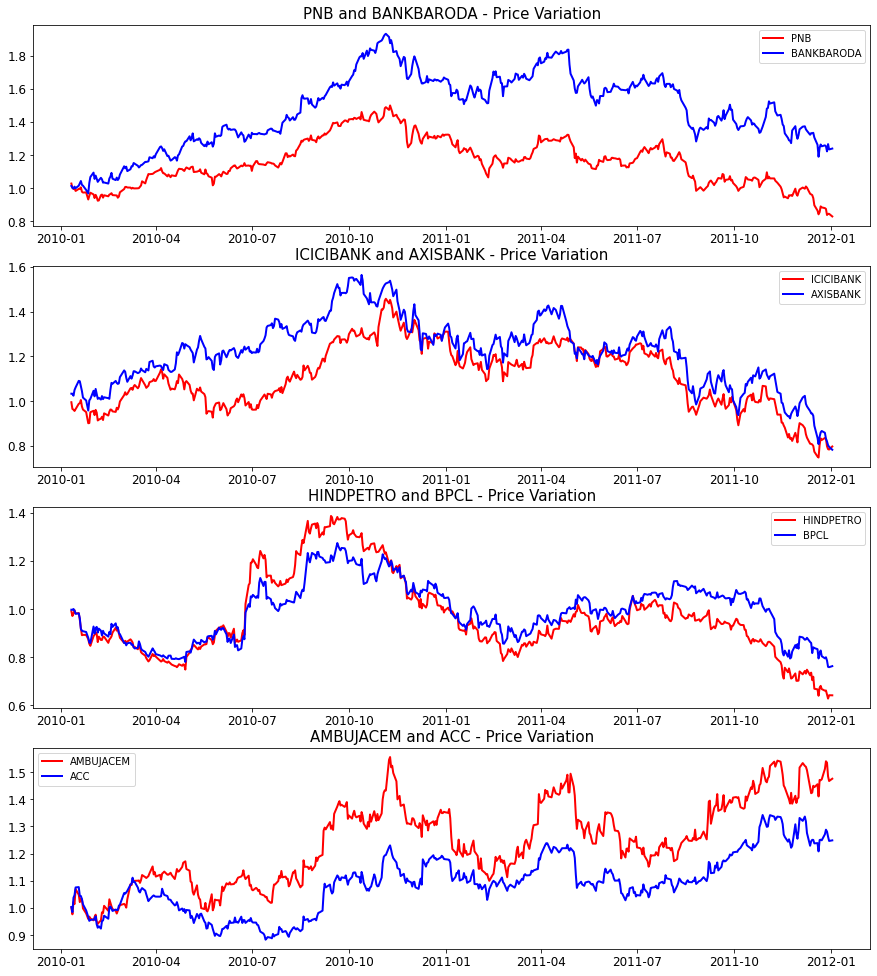

In [79]:
# edit out final_pairs definition and replace it with list of finalized pairs
final_pairs = half_life_checked

# Plotting the normalized prices for each pair
i1, i2 = 0, 495
fig, axes = plt.subplots(len(final_pairs),figsize=(15,17))
for i, pair in enumerate(final_pairs):
    #i = item[0]
    #pair = item[1]
    axes[i].plot(prices.Date.iloc[i1:i2], prices[pair[0]].iloc[i1:i2], linewidth=2, color='red', label=pair[0])
    axes[i].plot(prices.Date.iloc[i1:i2], prices[pair[1]].iloc[i1:i2], linewidth=2, color='blue', label=pair[1])
    axes[i].set_title(pair[0]+' and '+pair[1]+' - Price Variation', fontsize=15)
    axes[i].legend(fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

In [80]:
# Creating dataframe with ratios
ratios = dict()
for pair in final_pairs:
    ratios[pair[0]+' '+ pair[1]] = (prices[pair[0]]/prices[pair[1]])
ratios_df = pd.DataFrame(ratios)

In [81]:
ratios_list = []
mean = []
std = []
for pair in final_pairs:
    x = prices[pair[0]].iloc[i1:i2]/prices[pair[1]].iloc[i1:i2]
    ratios_list.append(x)
    mean.append(np.mean(x))
    std.append(np.std(x))


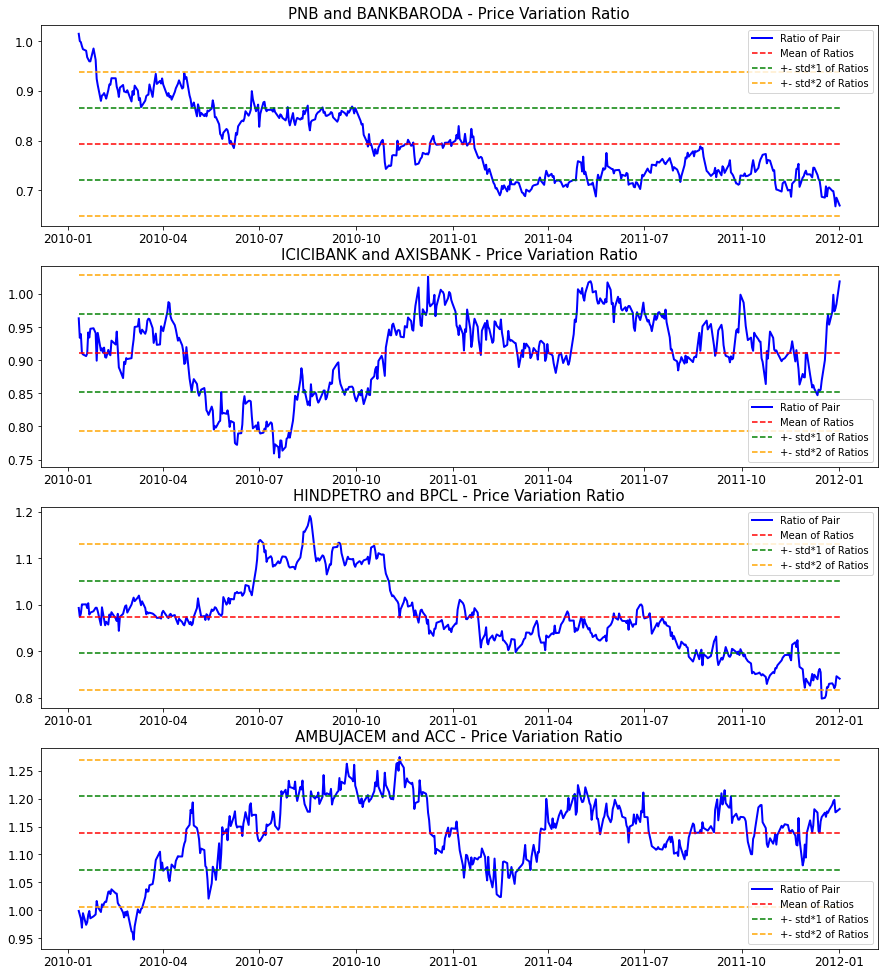

In [82]:
# Ratios for 2010-2012:
fig1, axes1 = plt.subplots(len(final_pairs),figsize=(15,17))
for i, pair in enumerate(final_pairs):
    mean_plt = [mean[i] for m in range(i1,i2)]
    std_once_minus = [mean[i] - std[i] for m in range(i1,i2)]
    std_once_plus = [mean[i] + std[i] for m in range(i1,i2)]
    std_twice_minus = [mean[i] - 2*std[i] for m in range(i1,i2)]
    std_twice_plus = [mean[i] + 2*std[i] for m in range(i1,i2)]
    
    axes1[i].plot(prices.Date.iloc[i1:i2], ratios_df[pair[0]+' '+ pair[1]].iloc[i1:i2], linewidth=2, color='blue', label='Ratio of Pair')
    axes1[i].plot(prices.Date.iloc[i1:i2], mean_plt, linewidth=1.5, color='red', label='Mean of Ratios', linestyle='--')
    axes1[i].plot(prices.Date.iloc[i1:i2], std_once_minus, linewidth=1.5, color='green', label='+- std*1 of Ratios', linestyle='--')
    axes1[i].plot(prices.Date.iloc[i1:i2], std_once_plus, linewidth=1.5, color='green', linestyle='--')
    axes1[i].plot(prices.Date.iloc[i1:i2], std_twice_minus, linewidth=1.5, color='orange', label='+- std*2 of Ratios', linestyle='--')
    axes1[i].plot(prices.Date.iloc[i1:i2], std_twice_plus, linewidth=1.5, color='orange', linestyle='--')
    axes1[i].set_title(pair[0]+' and '+pair[1]+' - Price Variation Ratio', fontsize=15)
    axes1[i].legend(fontsize=10)
    axes1[i].tick_params(axis='both', which='major', labelsize=12)

In [83]:
i3,i4 = 494,984
prices2 = pd.concat((df_un.Date.iloc[i3:],(df_un[df_un.columns[1:]].iloc[i3:] + 1).cumprod()),axis=1)
ratios2 = dict()
for pair in final_pairs:
    ratios2[pair[0]+' '+ pair[1]] = prices2[pair[0]]/prices2[pair[1]]

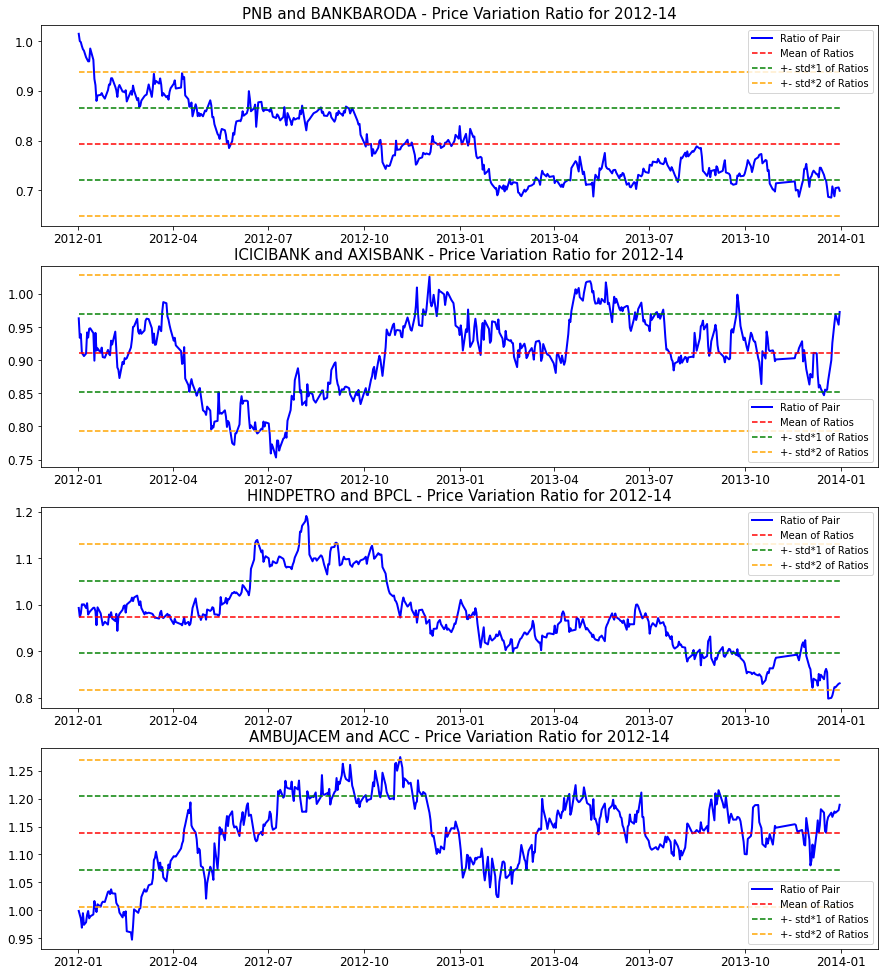

In [84]:
# Plotting ratios from 2012-2013:
# to change the timespan change i3 and i4
fig2, axes2 = plt.subplots(len(final_pairs),figsize=(15,17))
for i, pair in enumerate(final_pairs):
    mean_plt1 = [mean[i] for m in range(i3,i4)]
    std_once_minus1 = [mean[i] - std[i] for m in range(i3,i4)]
    std_once_plus1 = [mean[i] + std[i] for m in range(i3,i4)]
    std_twice_minus1 = [mean[i] - 2*std[i] for m in range(i3,i4)]
    std_twice_plus1 = [mean[i] + 2*std[i] for m in range(i3,i4)]

    axes2[i].plot(prices2.Date.iloc[0:i4-i3], ratios_df[pair[0]+' '+ pair[1]].iloc[0:i4-i3], linewidth=2, color='blue', label='Ratio of Pair')
    axes2[i].plot(prices2.Date.iloc[0:i4-i3], mean_plt1, linewidth=1.5, color='red', label='Mean of Ratios', linestyle='--')
    axes2[i].plot(prices2.Date.iloc[0:i4-i3], std_once_minus1, linewidth=1.5, color='green', label='+- std*1 of Ratios', linestyle='--')
    axes2[i].plot(prices2.Date.iloc[0:i4-i3], std_once_plus1, linewidth=1.5, color='green', linestyle='--')
    axes2[i].plot(prices2.Date.iloc[0:i4-i3], std_twice_minus1, linewidth=1.5, color='orange', label='+- std*2 of Ratios', linestyle='--')
    axes2[i].plot(prices2.Date.iloc[0:i4-i3], std_twice_plus1, linewidth=1.5, color='orange', linestyle='--')
    axes2[i].set_title(pair[0]+' and '+pair[1]+' - Price Variation Ratio for 2012-14', fontsize=15)
    axes2[i].legend(fontsize=10)
    axes2[i].tick_params(axis='both', which='major', labelsize=12)